In [211]:
import numpy as np
import pylab
import pandas as pd
import matplotlib.pyplot as plt

triads = [['BPS'+str(i),'BPS'+str(i+20),'BPS'+str(i+40)] for i in range(1,21)]
pd.options.display.max_columns= 79

## Robust peak detection algorithm (using z-scores)
* <b>lag</b> = the lag of the moving window. 
    * : the lag parameter determines how much your data will be smoothed and how adaptive the algorithm is to changes in the long-term average of the data. For example, a lag of 5 will use the last 5 observations to smooth the data. If you put lag at 10, it takes 10 'periods' before the algorithm's treshold is adjusted to any systematic changes in the long-term average. So choose the lag parameter based on the trending behavior of your data and how adaptive you want the algorithm to be. 
* <b>threshold</b> = the z-score at which the algorithm signals (peak or valley).
    * A threshold of 3.5 will signal if a datapoint is 3.5 standard deviations away from the moving mean.
* <b>influence</b> = the influence (between 0 and 1) of new signals on the mean and standard deviation. 
    * An influence of 0.5 gives signals half of the influence that normal datapoints have. Likewise, an influence of 0 ignores signals completely for recalculating the new threshold. When influence is set to zero, the standard deviation is calculated over the actual data (ignoring signals).  An influence of 0 is therefore the most robust option (but assumes stationarity); putting the influence option at 1 is least robust. For non-stationary data, the influence option should therefore be put somewhere between 0 and 1.




In [212]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [213]:
'''
moving window over 30 data points,
signals peaks/valleys if data point exceeds 3.5 std. deviation of moving mean
signals get 0.2 value of regular points for calculating moving mean
'''

lag = 15
threshold = 3.5
influence = 0.2

# C1 Data

In [214]:
df = pd.read_csv('validation/C1_RCIL_Data.csv')

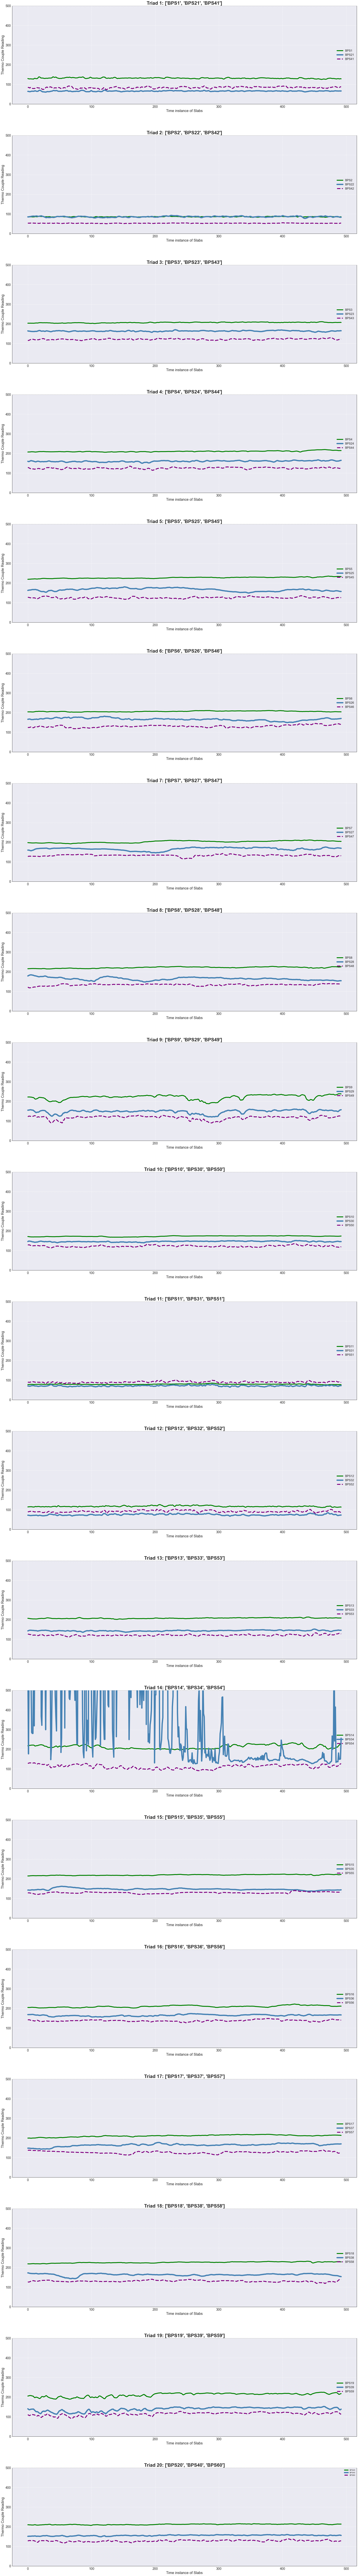

In [215]:
plt.style.use("seaborn")
fig, axs = plt.subplots(20, figsize=(30, 200))
colors= ['green', 'steelblue', 'purple']
l_width=[5,7,5]
l_style=['solid', 'solid', 'dashed']

for i in range(20):
    for j in range(3):
        axs[i].plot(df[triads[i][j]],label=triads[i][j], linewidth=l_width[j], color=colors[j], linestyle=l_style[j])
        
        axs[i].set_title('Triad '+ str(i+1)+ ': ' + str(triads[i]), fontsize=26, fontweight="bold")
        axs[i].set_ylabel('Thermo Couple Reading', fontsize=20)
        axs[i].set_xlabel('Time instance of Slabs', fontsize=20)
        axs[i].tick_params(axis='both', labelsize=18)
        axs[i].patch.set_edgecolor('black')
        axs[i].patch.set_linewidth('1')
        axs[i].legend(fontsize=16, loc='center right')
        axs[i].grid(axis = 'both', linestyle='--')
        axs[i].set_ylim(0,500)
        

plt.tight_layout(pad=10)
plt.legend()
plt.show()

In [216]:
c_result= []
funnel = []
for curr in triads[0:20]:
    
    y1 = df[curr[0]].to_numpy()
    y2 = df[curr[1]].to_numpy()
    y3 = df[curr[2]].to_numpy()
    
    num=len(y1)

    
    # Run algo with settings from above
    result1 = thresholding_algo(y1, lag=lag, threshold=threshold, influence=influence)
    result2 = thresholding_algo(y2, lag=lag, threshold=threshold, influence=influence)
    result3 = thresholding_algo(y3, lag=lag, threshold=threshold, influence=influence)

    #store dips of each thermocouple
    locations1=[]
    for i in range(len(result1['signals'])):
        if result1['signals'][i] == -1.0:
            locations1.append(i)

    locations2=[]
    for i in range(len(result2['signals'])):
        if result2['signals'][i] == -1.0:
            locations2.append(i)

    locations3=[]
    for i in range(len(result3['signals'])):
        if result3['signals'][i] == -1.0:
            locations3.append(i)
    
    result_set=[]
    for i in locations1:
        if ((i+1) in locations2 or i in locations2 or (i-1) in locations2) and ((i+1) in locations3 or i in locations3 or (i-1) in locations3):
            result_set.append(i)        
    #find intersection of dips
    '''s1 = set(locations1)
    s2 = set(locations2)
    s3 = set(locations3)
    set1 = s1.intersection(s2)
    result_set = set1.intersection(s3)'''
    result_set= list(result_set)
    result_set.sort()
    
    ## take only first from consecutive points
    for i in result_set:
        flag=True
        n=1
        while(flag):
            if (i+n) in result_set:
                result_set.remove(i+n)
                n=n+1
            else:
                flag=False
            
            
    funnel.append(len(result_set))
    c_result.append(result_set)
    print(curr[0] + ' + ' + curr[1] + ' + ' + curr[2] + ' = ' + str(result_set)+ '\n\n')

BPS1 + BPS21 + BPS41 = []


BPS2 + BPS22 + BPS42 = []


BPS3 + BPS23 + BPS43 = []


BPS4 + BPS24 + BPS44 = []


BPS5 + BPS25 + BPS45 = []


BPS6 + BPS26 + BPS46 = []


BPS7 + BPS27 + BPS47 = []


BPS8 + BPS28 + BPS48 = []


BPS9 + BPS29 + BPS49 = [250, 335, 439]


BPS10 + BPS30 + BPS50 = []


BPS11 + BPS31 + BPS51 = []


BPS12 + BPS32 + BPS52 = []


BPS13 + BPS33 + BPS53 = []


BPS14 + BPS34 + BPS54 = []


BPS15 + BPS35 + BPS55 = []


BPS16 + BPS36 + BPS56 = []


BPS17 + BPS37 + BPS57 = []


BPS18 + BPS38 + BPS58 = []


BPS19 + BPS39 + BPS59 = []


BPS20 + BPS40 + BPS60 = []




<AxesSubplot:>

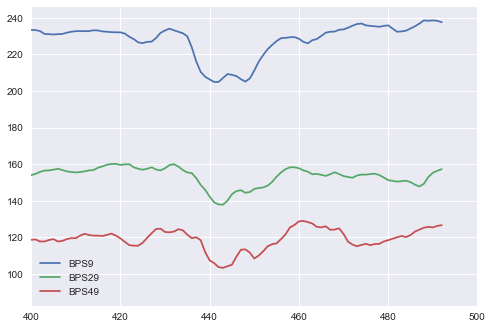

In [217]:
df[triads[8]].plot(xlim=([400,500]))

In [218]:
#dip points

df_val1=pd.DataFrame(columns=['Index','Time','Met_length','Triad', 'Type', 'Algo'])
counter=0
for i in range(len(c_result)):
    for j in range(len(c_result[i])):
        result=(c_result[i][j])
        df_val1.loc[counter]=pd.Series({'Index':result, 'Time':df.iloc[result]['TIME_STAMP'], 'Met_length':str(df.iloc[result]['MET_LENGTH']), 'Triad':triads[i], 'Type':'Wide','Algo': 'Z-Score'})
        counter=counter+1
        

c1_wide=df_val1.sort_values(by='Index', ascending=True)
print('-'*100)
print(' '*35+ 'C1 wide dips through Z-Score')
print('-'*100)
c1_wide

----------------------------------------------------------------------------------------------------
                                   C1 wide dips through Z-Score
----------------------------------------------------------------------------------------------------


Index               Time Met_length                 Triad  Type     Algo
0   250  26-05-22 10:39:59   7541.225  [BPS9, BPS29, BPS49]  Wide  Z-Score
1   335  26-05-22 10:42:41   7444.607  [BPS9, BPS29, BPS49]  Wide  Z-Score
2   439  26-05-22 10:45:57   7443.665  [BPS9, BPS29, BPS49]  Wide  Z-Score

In [219]:
c1_wide.to_csv('C1_RCIL.csv')

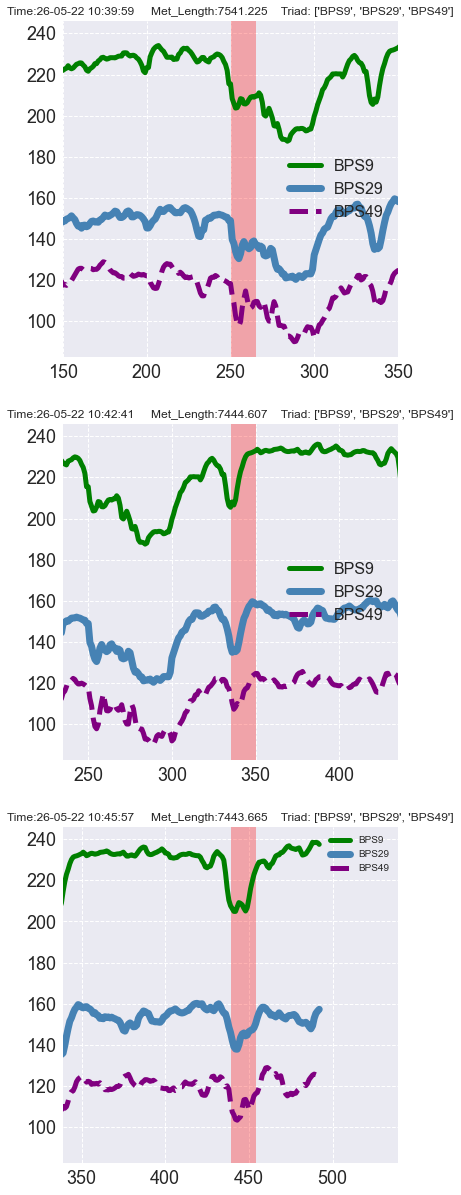

In [220]:
#plotting detected dips
plt.style.use("seaborn")

fig, axs = plt.subplots(len(c1_wide), figsize=(6, 7*len(c1_wide)))
for i in range(len(c1_wide)):
    Title= str('Time:'+c1_wide.iloc[i]['Time'])+'     Met_Length:'+str(c1_wide.iloc[i]['Met_length'])+'    Triad: '+str(c1_wide.iloc[i]['Triad'])
    det= int(c1_wide.iloc[i]['Index'])
    tr= c1_wide.iloc[i]['Triad']
    
    colors= ['green', 'steelblue', 'purple']
    l_width=[5,7,5]
    l_style=['solid', 'solid', 'dashed']
    for j in range(3):
        axs[i].plot(df[tr[j]],label=tr[j], linewidth=l_width[j], color=colors[j], linestyle=l_style[j])
    axs[i].axvspan(det,det+15, facecolor='r', alpha=0.3)
    axs[i].set_title(Title)
    axs[i].tick_params(axis='both', labelsize=18)
    
    axs[i].legend(fontsize=16, loc='center right')
    axs[i].grid(axis = 'both', linestyle='--')
    axs[i].set_xlim(det-100,det+100)
plt.legend()
plt.show()
    

# C2 Data

In [221]:
df = pd.read_csv('validation/C2_RCIL_DATA.csv')

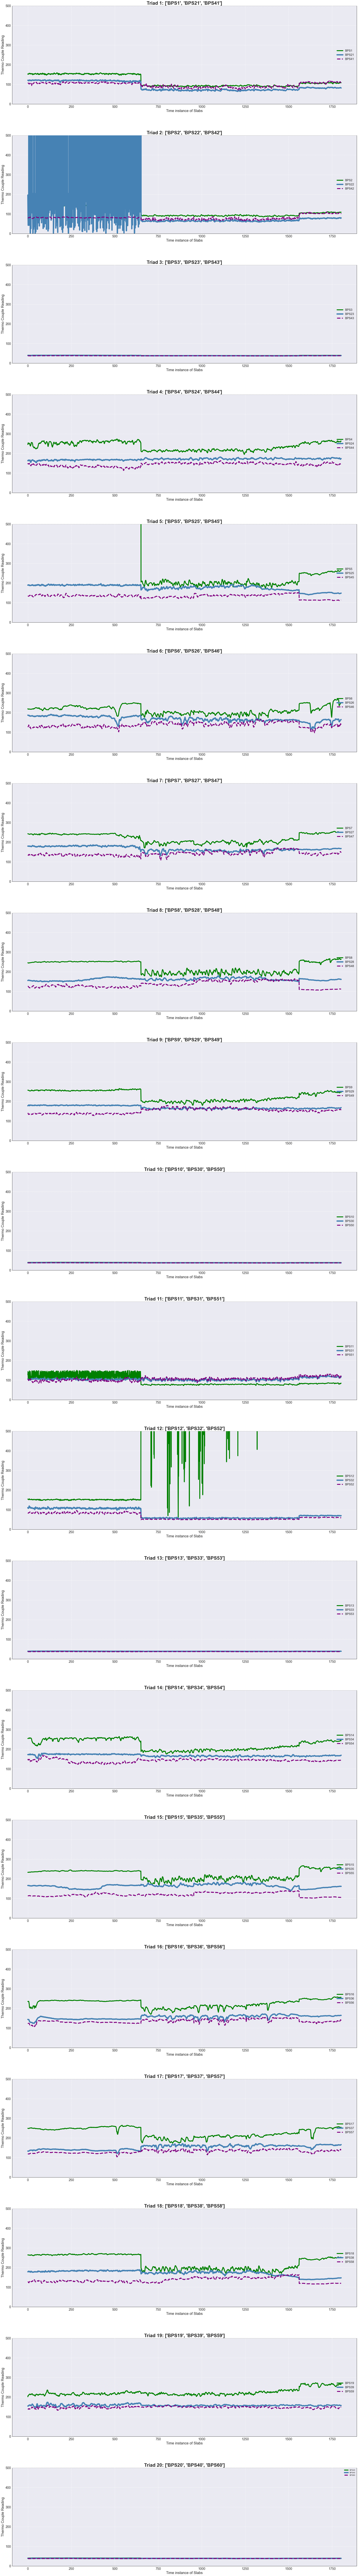

In [222]:
plt.style.use("seaborn")
fig, axs = plt.subplots(20, figsize=(30, 200))
colors= ['green', 'steelblue', 'purple']
l_width=[5,7,5]
l_style=['solid', 'solid', 'dashed']

for i in range(20):
    for j in range(3):
        axs[i].plot(df[triads[i][j]],label=triads[i][j], linewidth=l_width[j], color=colors[j], linestyle=l_style[j])
        
        axs[i].set_title('Triad '+ str(i+1)+ ': ' + str(triads[i]), fontsize=26, fontweight="bold")
        axs[i].set_ylabel('Thermo Couple Reading', fontsize=20)
        axs[i].set_xlabel('Time instance of Slabs', fontsize=20)
        axs[i].tick_params(axis='both', labelsize=18)
        axs[i].patch.set_edgecolor('black')
        axs[i].patch.set_linewidth('1')
        axs[i].legend(fontsize=16, loc='center right')
        axs[i].grid(axis = 'both', linestyle='--')
        axs[i].set_ylim(0,500)
        

plt.tight_layout(pad=10)
plt.legend()
plt.show()

In [223]:
c_result= []
funnel = []
for curr in triads[0:20]:
    
    y1 = df[curr[0]].to_numpy()
    y2 = df[curr[1]].to_numpy()
    y3 = df[curr[2]].to_numpy()
    
    num=len(y1)

    
    # Run algo with settings from above
    result1 = thresholding_algo(y1, lag=lag, threshold=threshold, influence=influence)
    result2 = thresholding_algo(y2, lag=lag, threshold=threshold, influence=influence)
    result3 = thresholding_algo(y3, lag=lag, threshold=threshold, influence=influence)

    #store dips of each thermocouple
    locations1=[]
    for i in range(len(result1['signals'])):
        if result1['signals'][i] == -1.0:
            locations1.append(i)

    locations2=[]
    for i in range(len(result2['signals'])):
        if result2['signals'][i] == -1.0:
            locations2.append(i)

    locations3=[]
    for i in range(len(result3['signals'])):
        if result3['signals'][i] == -1.0:
            locations3.append(i)
    
    result_set=[]
    for i in locations1:
        if ((i+1) in locations2 or i in locations2 or (i-1) in locations2) and ((i+1) in locations3 or i in locations3 or (i-1) in locations3):
            result_set.append(i)        
    #find intersection of dips
    '''s1 = set(locations1)
    s2 = set(locations2)
    s3 = set(locations3)
    set1 = s1.intersection(s2)
    result_set = set1.intersection(s3)'''
    result_set= list(result_set)
    result_set.sort()
    
    ## take only first from consecutive points
    for i in result_set:
        flag=True
        n=1
        while(flag):
            if (i+n) in result_set:
                result_set.remove(i+n)
                n=n+1
            else:
                flag=False
            
            
    funnel.append(len(result_set))
    c_result.append(result_set)
    print(curr[0] + ' + ' + curr[1] + ' + ' + curr[2] + ' = ' + str(result_set)+ '\n\n')

BPS1 + BPS21 + BPS41 = [651, 1753]


BPS2 + BPS22 + BPS42 = []


BPS3 + BPS23 + BPS43 = []


BPS4 + BPS24 + BPS44 = []


BPS5 + BPS25 + BPS45 = []


BPS6 + BPS26 + BPS46 = [1625, 1745]


BPS7 + BPS27 + BPS47 = [757]


BPS8 + BPS28 + BPS48 = []


BPS9 + BPS29 + BPS49 = []


BPS10 + BPS30 + BPS50 = [1530, 1532, 1790]


BPS11 + BPS31 + BPS51 = [1311, 1665]


BPS12 + BPS32 + BPS52 = []


BPS13 + BPS33 + BPS53 = []


BPS14 + BPS34 + BPS54 = []


BPS15 + BPS35 + BPS55 = []


BPS16 + BPS36 + BPS56 = [1093, 1255, 1377]


BPS17 + BPS37 + BPS57 = [507, 730, 1024, 1629]


BPS18 + BPS38 + BPS58 = []


BPS19 + BPS39 + BPS59 = []


BPS20 + BPS40 + BPS60 = [1707]




In [224]:
#dip points

df_val2=pd.DataFrame(columns=['Index','Time','Met_length','Triad', 'Type', 'Algo', 'Name'])
counter=0
for i in range(len(c_result)):
    for j in range(len(c_result[i])):
        result=(c_result[i][j])
        df_val2.loc[counter]=pd.Series({'Index':result, 'Time':df.iloc[result]['TIME_STAMP'], 'Met_length':str(df.iloc[result]['MET_LENGTH']), 'Triad':triads[i], 'Type':'Wide','Algo': 'Z-Score', 'Name': " ".join(triads[i])})
        counter=counter+1
        

c2_wide=df_val2.sort_values(by='Index', ascending=True)
print('-'*100)
print(' '*35+ 'C2 wide dips through Z-Score')
print('-'*100)
c2_wide

----------------------------------------------------------------------------------------------------
                                   C2 wide dips through Z-Score
----------------------------------------------------------------------------------------------------


Index              Time Met_length                  Triad  Type     Algo  \
13   507  24-05-2022 16:11   7144.118  [BPS17, BPS37, BPS57]  Wide  Z-Score   
0    651  25-05-2022 13:12   6744.137   [BPS1, BPS21, BPS41]  Wide  Z-Score   
14   730  25-05-2022 13:14   6477.224  [BPS17, BPS37, BPS57]  Wide  Z-Score   
4    757  25-05-2022 13:15   6510.245   [BPS7, BPS27, BPS47]  Wide  Z-Score   
15  1024  25-05-2022 13:33   6492.705  [BPS17, BPS37, BPS57]  Wide  Z-Score   
10  1093  25-05-2022 13:35   6504.732  [BPS16, BPS36, BPS56]  Wide  Z-Score   
11  1255  25-05-2022 13:40     6382.7  [BPS16, BPS36, BPS56]  Wide  Z-Score   
8   1311  25-05-2022 13:51     6382.7  [BPS11, BPS31, BPS51]  Wide  Z-Score   
12  1377  25-05-2022 13:53     6382.7  [BPS16, BPS36, BPS56]  Wide  Z-Score   
5   1530  25-05-2022 13:58   6556.818  [BPS10, BPS30, BPS50]  Wide  Z-Score   
6   1532  25-05-2022 13:58   6556.818  [BPS10, BPS30, BPS50]  Wide  Z-Score   
2   1625  25-05-2022 22:58   6744.188   [BPS6, BPS26, BPS46]  Wide  Z-Score   
16  1629  25-05-2022 22:58   6747.912  [BPS17, BPS37, BPS57]  Wide  Z-Score   
9   1665  25-05-2022 22:59   6744.127  [BPS11, BPS31, BPS51]  Wide  Z-Score   
17  1707  25-05-2022 23:00    6826.05  [BPS20, BPS40, BPS60]  Wide  Z-Score   
3   1745  25-05-2022 23:01   7064.708   [BPS6, BPS26, BPS46]  Wide  Z-Score   
1   1753  25-05-2022 23:02   7104.414   [BPS1, BPS21, BPS41]  Wide  Z-Score   
7   1790  25-05-2022 23:03   7134.301  [BPS10, BPS30, BPS50]  Wide  Z-Score   

                 Name  
13  BPS17 BPS37 BPS57  
0    BPS1 BPS21 BPS41  
14  BPS17 BPS37 BPS57  
4    BPS7 BPS27 BPS47  
15  BPS17 BPS37 BPS57  
10  BPS16 BPS36 BPS56  
11  BPS16 BPS36 BPS56  
8   BPS11 BPS31 BPS51  
12  BPS16 BPS36 BPS56  
5   BPS10 BPS30 BPS50  
6   BPS10 BPS30 BPS50  
2    BPS6 BPS26 BPS46  
16  BPS17 BPS37 BPS57  
9   BPS11 BPS31 BPS51  
17  BPS20 BPS40 BPS60  
3    BPS6 BPS26 BPS46  
1    BPS1 BPS21 BPS41  
7   BPS10 BPS30 BPS50

In [225]:
c2_wide=c2_wide[~((c2_wide['Name'].str.contains('BPS11')) | (c2_wide['Name'].str.contains('BPS1 '))| (c2_wide['Name'].str.contains('BPS12')) | (c2_wide['Name'].str.contains('BPS2 ')) | (c2_wide['Name'].str.contains('BPS20')) | (c2_wide['Name'].str.contains('BPS10')))]
c2_wide=c2_wide.drop(columns=['Name'])

In [226]:



c2_wide.to_csv('C2_RCIL.csv')

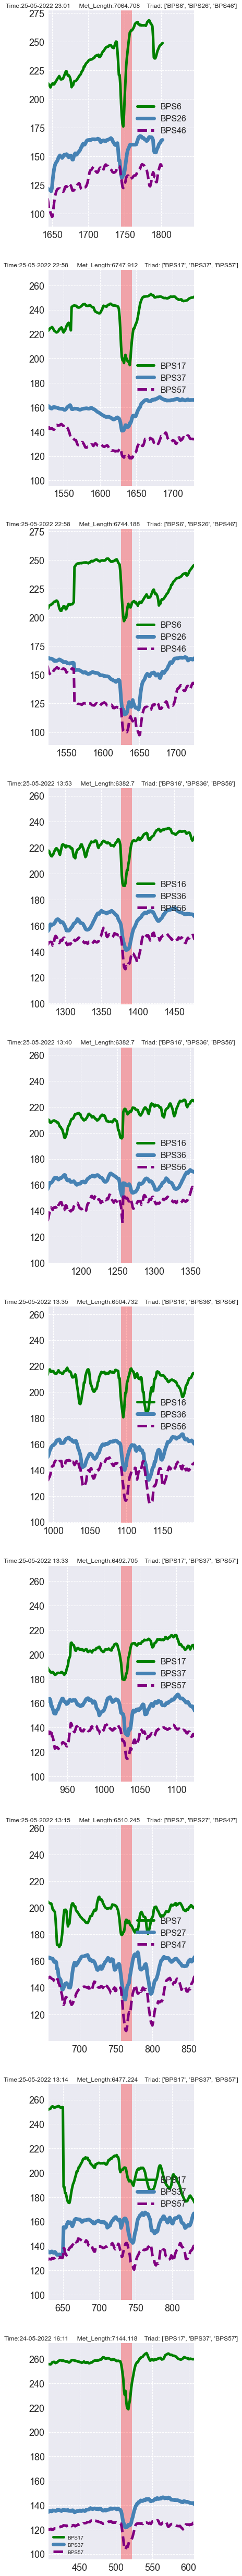

In [202]:
#plotting detected dips

plt.style.use("seaborn")

fig, axs = plt.subplots(len(c2_wide), figsize=(5, 9*len(c2_wide)))
for i in range(len(c2_wide)):
    Title= str('Time:'+c2_wide.iloc[i]['Time'])+'     Met_Length:'+str(c2_wide.iloc[i]['Met_length'])+'    Triad: '+str(c2_wide.iloc[i]['Triad'])
    det= int(c2_wide.iloc[i]['Index'])
    tr= c2_wide.iloc[i]['Triad']
    
    colors= ['green', 'steelblue', 'purple']
    l_width=[5,7,5]
    l_style=['solid', 'solid', 'dashed']
    for j in range(3):
        axs[i].plot(df[tr[j]],label=tr[j], linewidth=l_width[j], color=colors[j], linestyle=l_style[j])
    axs[i].axvspan(det,det+15, facecolor='r', alpha=0.3)
    axs[i].set_title(Title)
    axs[i].tick_params(axis='both', labelsize=18)
    
    axs[i].legend(fontsize=16, loc='center right')
    axs[i].grid(axis = 'both', linestyle='--')
    axs[i].set_xlim(det-100,det+100)
plt.legend()
plt.show()
    